## Installing and Importing Relevant Libraries
First, we install necessary libraries such as transformers, xgboost, and gensim, which are not pre-installed in Google Colab. Then we import various Python packages including pandas for data manipulation, sklearn for machine learning, and transformers for natural language processing.

In [2]:
!pip install transformers

In [3]:
!pip install xgboost

In [4]:
!pip install gensim

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import random
from datetime import timedelta, datetime
from transformers import pipeline
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models

## Connecting Google Drive
This block mounts the Google Drive to the Colab environment, allowing access to files stored in Google Drive. This is particularly useful for large datasets or when integrating workflows with Google Drive.

In [6]:
# Connecting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Datasets from Google Drive
Datasets are loaded from various file paths on Google Drive. This includes CSV and Excel files containing housing data, Google search results, Reddit scraped data, economic indicators, and more.

In [7]:
# Path to files in Google Drive
file_path1 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/filtered_FL_data.csv"
housing_index_data = pd.read_csv(file_path1)

file_path4 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/Scraped Data/Google_Search_Results.xlsx"
google_results = pd.read_excel(file_path4)

file_path9 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/Scraped Data/Scrapped Data.csv"
reddit_scrape = pd.read_csv(file_path9)

file_path2 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/External Data/Cleaned Datasets/monthly_cofi.xlsx"
COFI_data = pd.read_excel(file_path2)

file_path3 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/External Data/Cleaned Datasets/Mortgage Rates.xlsx"
mortgage_rates_data = pd.read_excel(file_path3)

file_path5 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/External Data/Cleaned Datasets/Employment Rate.xlsx"
employement_data = pd.read_excel(file_path5)

file_path6 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/External Data/Cleaned Datasets/Active Listings.csv"
active_listing_data = pd.read_csv(file_path6)

file_path7 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/External Data/Cleaned Datasets/Housing units.xlsx"
housing_units_data = pd.read_excel(file_path7)

file_path8 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/External Data/Cleaned Datasets/Appraisal Data.csv"
appraisal_data = pd.read_csv(file_path8)

file_path10 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/ChatGPT/ChatGPT predictions.xlsx"
chatgpt_data = pd.read_excel(file_path10)

file_path11 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/External Data/Cleaned Datasets/Florida Flight Data.csv"
flights_data = pd.read_csv(file_path11)

file_path12 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/External Data/Cleaned Datasets/WFH Percentage.csv"
wfh_data = pd.read_csv(file_path12)

file_path13 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/ChatGPT/2008 crisis HPI predictions.xlsx"
ChatGPT_2008_data = pd.read_excel(file_path13)

file_path14 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/External Data/Cleaned Datasets/FEDFUNDS.xlsx"
fedfunds_data = pd.read_excel(file_path14)

file_path15 = "/content/drive/My Drive/School/Fall'23/Capstone/Data/External Data/Cleaned Datasets/GDP.xlsx"
gdp_data = pd.read_excel(file_path15)

## Data Cleaning
The data undergoes preprocessing, such as converting date columns to datetime objects, filtering data, and reshaping it. This step is crucial for preparing the datasets for analysis and modeling.

In [8]:
# Convert year and month to a date
housing_index_data['Date'] = pd.to_datetime(housing_index_data['Year'].astype(str) + '-' + housing_index_data['Month'].astype(str))

print(housing_index_data)

       Year  Month GEO_Type                  GEO_Name GEO_Code   Index_NSA  \
0      1975      1     CBSA  Cape Coral-Fort Myers FL    15980   33.895765   
1      1975      2     CBSA  Cape Coral-Fort Myers FL    15980   35.095020   
2      1975      3     CBSA  Cape Coral-Fort Myers FL    15980   36.988779   
3      1975      4     CBSA  Cape Coral-Fort Myers FL    15980   39.392752   
4      1975      5     CBSA  Cape Coral-Fort Myers FL    15980   39.639283   
...     ...    ...      ...                       ...      ...         ...   
13427  2023      4     CBSA           The Villages FL    45540  289.969625   
13428  2023      5     CBSA           The Villages FL    45540  291.368514   
13429  2023      6     CBSA           The Villages FL    45540  292.990417   
13430  2023      7     CBSA           The Villages FL    45540  294.538803   
13431  2023      8     CBSA           The Villages FL    45540  294.707865   

         Index_SA       Date  
0       33.915246 1975-01-01  
1

In [9]:
# Filtering the housing_index_data for rows where GEO_Name contains 'FL'
fl_housing_data = housing_index_data[housing_index_data["GEO_Type"].str.contains("State")]

In [10]:
appraisal_data = appraisal_data[appraisal_data["GEONAME"].str.contains("Florida")]
appraisal_data = appraisal_data[appraisal_data['PURPOSE'] == 'Both']
appraisal_data = appraisal_data[appraisal_data['CATEGORY1'] == 'All Appraisals']
appraisal_data = appraisal_data[appraisal_data['QUARTER'] != 5]

In [11]:
# Function to generate dates for each quarter
def generate_dates(year, quarter):
    if quarter == 1:
        months = ['01', '02', '03']
    elif quarter == 2:
        months = ['04', '05', '06']
    elif quarter == 3:
        months = ['07', '08', '09']
    else:
        months = ['10', '11', '12']

    return [f'{year}-{month}-01' for month in months]

# Apply the function and explode the result
appraisal_data['Date'] = appraisal_data.apply(lambda row: generate_dates(row['YEAR'], row['QUARTER']), axis=1)
appraisal_data = appraisal_data.explode('Date')

# Display the DataFrame
#print(appraisal_data)

In [12]:
appraisal_data = appraisal_data.pivot_table(index='Date', columns='SERIES', values='VALUE', aggfunc='sum')  # or aggfunc=np.mean

# Resetting the index to convert 'Date' to a column
appraisal_data.reset_index(inplace=True)

# Display the pivoted DataFrame
#print(appraisal_data)


## NLP using Hugging Face Transformers library
Sentiment analysis is performed on text data using pre-trained models from Hugging Face. This is used to derive insights from text-based data like Google search results and Reddit posts.

The sentiment value is determined by the product of the sentiment score, representing the confidence level of the sentiment analysis model's classification, and the sentiment itself, with positive, neutral, and negative sentiments assigned values of 1, 0, and -1, respectively.

### Using Financial news model

In [13]:
# Load a pre-trained sentiment analysis model
sentiment_pipeline = pipeline('sentiment-analysis', model='mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis')

# Apply the sentiment analysis model to the google results data
google_results['sentiment_results'] = google_results['Text'].apply(lambda x: sentiment_pipeline(x[:512]))  # we limit size to 512 tokens

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [14]:
# Extract and process the sentiment analysis results
google_sentiment = google_results
google_sentiment['sentiment'] = google_results['sentiment_results'].apply(lambda x: x[0]['label'])
google_sentiment['sentiment_score'] = google_results['sentiment_results'].apply(lambda x: x[0]['score'])

# Create sentiment_value to use for analysis. Note - Sentiment score gives confidence of the model on the classification of sentiment
def adjust_sentiment_score(row):
    if row['sentiment'] == 'negative':
        return -1 * row['sentiment_score']
    elif row['sentiment'] == 'neutral':
        return 0
    else:
        return 1*row['sentiment_score']

google_sentiment['sentiment_value'] = google_sentiment.apply(adjust_sentiment_score, axis=1)


# Save the DataFrame to a new CSV file or analyze it
google_sentiment.to_csv('sentiment_analysis_results.csv', index=False)

# Print the first few rows of the dataframe to verify
#print(google_sentiment)

In [15]:
google_sentiment['Date'] = pd.to_datetime(google_sentiment['Date'])
google_sentiment['Date'] = pd.to_datetime(google_sentiment['Date'].dt.to_period('M').astype(str) + '-01')

In [16]:
keywords = ['COVID-19', 'quarantine', 'lockdown', 'covid', 'fed', 'rates', 'coronavirus', 'Real estate','Housing market','Property prices','Mortgage rates','Real estate investing','Housing bubble','Rental market',
    'Home buying','Home selling', 'Foreclosure','Property taxes','Market analysis','Real estate trends','Homeownership','Land value','Suburb','Neighborhood','Spacious','Market crash','Homeowner',
    'Affordable','estate','Housing', 'Property','Mortgage','Investing','bubble','Rental','rentals','Market','Land','br','bhk','flat','apartment','duplex',
    'townhouse','renting','condo','insurance','Homeowners','hoa','housing bubble','Homebuyer','homes','home','relocation','relocated','realtors','gentrification','listings',
    'appraisal','desantis','houses']

# Function to count total keywords in a title
def count_total_keywords(title):
    return sum(title.lower().count(keyword) for keyword in keywords)

# Apply the function to each row of the title column
google_sentiment['total_keyword_count'] = google_sentiment['Text'].apply(count_total_keywords)

In [17]:
google_sentiment['count'] = google_sentiment.groupby('Date')['Date'].transform('count')
google_sentiment_count = google_sentiment.groupby(['Date', 'count'])['sentiment_value'].mean().reset_index()
google_keyword_count = google_sentiment.groupby(['Date'])['total_keyword_count'].sum().reset_index()
google_keyword_count['Date'] = pd.to_datetime(google_keyword_count['Date'])

### Using Twitter model

In [18]:
# Load a pre-trained sentiment analysis model
sentiment_pipeline = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment-latest')

# Apply the sentiment analysis model to the Reddit data
reddit_scrape['sentiment_results2'] = reddit_scrape['Title'].apply(lambda x: sentiment_pipeline(x[:512]))  # we limit size to 512 tokens

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [19]:
# Extract and process the sentiment analysis results
reddit_sentiment = reddit_scrape
reddit_sentiment['sentiment2'] = reddit_sentiment['sentiment_results2'].apply(lambda x: x[0]['label'])
reddit_sentiment['sentiment_score2'] = reddit_sentiment['sentiment_results2'].apply(lambda x: x[0]['score'])

# Create sentiment_value to use for analysis. Note - Sentiment score gives confidence of the model on the classification of sentiment
def adjust_sentiment_score(row):
    if row['sentiment2'] == 'negative':
        return -1 * row['sentiment_score2']
    elif row['sentiment2'] == 'neutral':
        return 0
    else:
        return row['sentiment_score2']

reddit_sentiment['sentiment_value2'] = reddit_sentiment.apply(adjust_sentiment_score, axis=1)


# Save the DataFrame to a new CSV file or analyze it
reddit_sentiment.to_csv('sentiment_analysis_results2.csv', index=False)

In [20]:
reddit_sentiment['Date Only'] = pd.to_datetime(reddit_sentiment['Date Only'])
reddit_sentiment['Date Only'] = pd.to_datetime(reddit_sentiment['Date Only'].dt.to_period('M').astype(str) + '-01')

In [21]:
keywords = ['COVID-19', 'quarantine', 'lockdown', 'covid', 'fed', 'rates', 'coronavirus', 'Real estate','Housing market','Property prices','Mortgage rates','Real estate investing','Housing bubble','Rental market',
    'Home buying','Home selling', 'Foreclosure','Property taxes','Market analysis','Real estate trends','Homeownership','Land value','Suburb','Neighborhood','Spacious','Market crash','Homeowner',
    'Affordable','estate','Housing', 'Property','Mortgage','Investing','bubble','Rental','rentals','Market','Land','br','bhk','flat','apartment','duplex',
    'townhouse','renting','condo','insurance','Homeowners','hoa','housing bubble','Homebuyer','homes','home','relocation','relocated','realtors','gentrification','listings',
    'appraisal','desantis','houses']

# Function to count total keywords in a title
def count_total_keywords(title):
    return sum(title.lower().count(keyword) for keyword in keywords)

# Apply the function to each row of the title column
reddit_sentiment['total_keyword_count2'] = reddit_sentiment['Title'].apply(count_total_keywords)


In [22]:
reddit_sentiment['count2'] = reddit_sentiment.groupby('Date Only')['Date Only'].transform('count')
reddit_scrape_count = reddit_sentiment.groupby(['Date Only', 'count2'])['sentiment_value2'].mean().reset_index()
reddit_keyword_count = reddit_sentiment.groupby(['Date Only'])['total_keyword_count2'].sum().reset_index()

## Merging Datasets for Prediction
This section merges various datasets into a single DataFrame, which will be used for predictive modeling. This is a crucial step in data analysis, combining different data sources for comprehensive analysis.

In [23]:
flights_data['Date'] = pd.to_datetime(flights_data['Date'])
wfh_data['Date'] = pd.to_datetime(wfh_data['Date'])

In [24]:
active_listing_data["DATE"] = pd.to_datetime(active_listing_data["DATE"])
housing_units_data["observation_date"] = pd.to_datetime(housing_units_data["observation_date"])
appraisal_data["Date"] = pd.to_datetime(appraisal_data["Date"])

In [25]:
COFI_data = COFI_data[COFI_data["Year-Month"].isin(fl_housing_data["Date"])]

In [26]:
# Converting the 'Date' column in fl_housing_data to datetime
fl_housing_data["Date"] = pd.to_datetime(fl_housing_data["Date"])

# Merging the dataframes
merged_data = fl_housing_data.merge(COFI_data, left_on="Date", right_on="Year-Month", how="left")
merged_data = merged_data.merge(mortgage_rates_data, left_on="Date", right_on="Year-Month", how="left")
merged_data = merged_data.merge(google_sentiment_count, left_on="Date", right_on="Date", how="left")
merged_data = merged_data.merge(reddit_scrape_count, left_on="Date", right_on="Date Only", how="left")
merged_data = merged_data.merge(employement_data, left_on="Date", right_on="Date", how="left")
merged_data = merged_data.merge(active_listing_data, left_on="Date", right_on="DATE", how="left")
merged_data = merged_data.merge(housing_units_data, left_on="Date", right_on="observation_date", how="left")
merged_data = merged_data.merge(appraisal_data, left_on="Date", right_on="Date", how="left")
merged_data = merged_data.merge(chatgpt_data, left_on="Date", right_on="Date", how="left")
merged_data = merged_data.merge(flights_data, left_on="Date", right_on="Date", how="left")
merged_data = merged_data.merge(wfh_data, left_on="Date", right_on="Date", how="left")
merged_data = merged_data.merge(fedfunds_data, left_on="Date", right_on="Date", how="left")
merged_data = merged_data.merge(reddit_keyword_count, left_on="Date", right_on="Date Only", how="left")
merged_data = merged_data.merge(google_keyword_count, left_on="Date", right_on="Date", how="left")
merged_data = merged_data.merge(gdp_data, left_on="Date", right_on="Date", how="left")


# Selecting the relevant columns
final_data = merged_data[["Date",'Year_x','Month_x', "Index_SA", "The Federal Cost of Funds Index", "Average U.S. 30 yr FRM", 'FORCE', 'RATE (%)','ACTLISCOUFL', 'New Pvt housing units',  'Count of Appraisals', 'Mean Appraised Value', '75% Quartile of Appraised Value', '25% Quartile of Appraised Value',"sentiment_value", 'sentiment_value2', 'count', 'count2', 'TOTAL', 'WFH_Share', 'FEDFUNDS', 'total_keyword_count', 'total_keyword_count2', 'GDP']]
#final_data

<ipython-input-26-9709bb410e72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fl_housing_data["Date"] = pd.to_datetime(fl_housing_data["Date"])


## Modelling Prep
Preparation for modeling includes creating lagged variables, handling missing values, and defining features (predictors) and labels (targets).

In [27]:
min_date = final_data['Date'].min()
# removed - 'Mean Appraised Value', 'count'

# Convert 'Date' to a numeric feature, for example days since start of the data
final_data['DaysSinceStart'] = (final_data['Date'] - final_data['Date'].min()).dt.days

# Creating a lagged variable of Index_SA
final_data['Index_SA_Lag1'] = final_data['Index_SA'].shift(2)

# Fill missing values if any
final_data = final_data.fillna(method='ffill')

# Define your features and label
X = final_data[['DaysSinceStart','Month_x', 'New Pvt housing units',"The Federal Cost of Funds Index",  "Average U.S. 30 yr FRM", 'FORCE', 'RATE (%)', 'ACTLISCOUFL',  'Count of Appraisals', 'sentiment_value', 'sentiment_value2','count2','TOTAL',  'WFH_Share', 'FEDFUNDS', 'total_keyword_count','75% Quartile of Appraised Value','25% Quartile of Appraised Value', 'total_keyword_count2', 'GDP', 'Index_SA_Lag1']]
final_data
y = final_data['Index_SA']

# Split the data based on the date
split_date = pd.Timestamp('2020-03-01')
train = final_data.loc[final_data['Date'] < split_date]
test = final_data.loc[final_data['Date'] >= split_date]

X_train = train[['DaysSinceStart','Month_x',  'New Pvt housing units', "The Federal Cost of Funds Index",  "Average U.S. 30 yr FRM",'FORCE', 'RATE (%)', 'ACTLISCOUFL', 'Count of Appraisals', "sentiment_value",  'sentiment_value2' ,'count2', 'TOTAL',  'WFH_Share','FEDFUNDS','75% Quartile of Appraised Value','25% Quartile of Appraised Value', 'total_keyword_count', 'total_keyword_count2','GDP', 'Index_SA_Lag1']]
y_train = train['Index_SA']
X_test = test[['DaysSinceStart','Month_x', 'New Pvt housing units', "The Federal Cost of Funds Index",  "Average U.S. 30 yr FRM", 'FORCE', 'RATE (%)','ACTLISCOUFL','Count of Appraisals',"sentiment_value", 'sentiment_value2' ,'count2','TOTAL', 'WFH_Share', 'FEDFUNDS','75% Quartile of Appraised Value','25% Quartile of Appraised Value','total_keyword_count', 'total_keyword_count2','GDP',  'Index_SA_Lag1']]
y_test = test['Index_SA']

<ipython-input-27-5ead1035c720>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['DaysSinceStart'] = (final_data['Date'] - final_data['Date'].min()).dt.days
<ipython-input-27-5ead1035c720>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Index_SA_Lag1'] = final_data['Index_SA'].shift(2)


## Correlation Plot
A heatmap is generated to visualize correlations between different features. This is helpful to understand the relationships among variables.

<ipython-input-28-251ae45e188a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = final_data.corr()


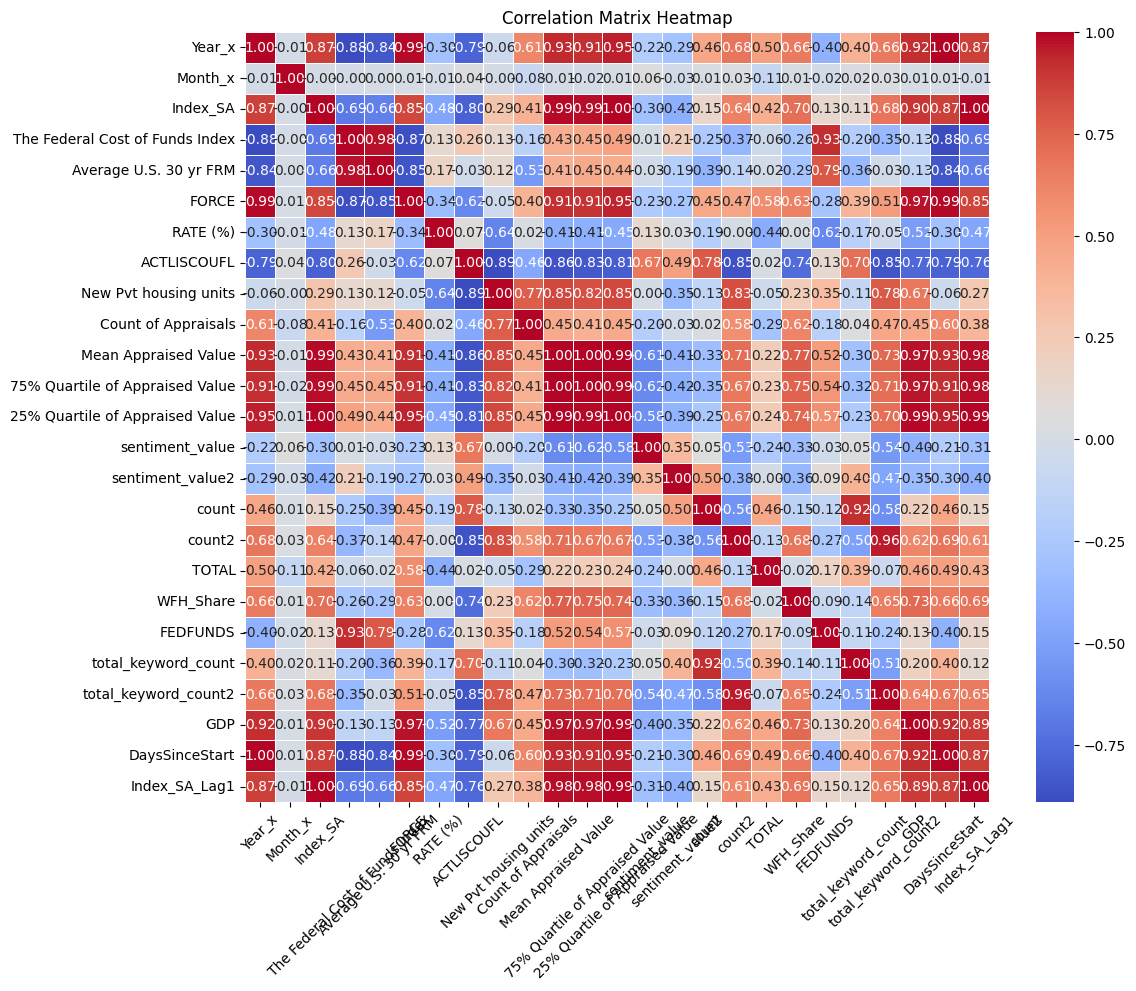

In [28]:
correlation_matrix = final_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Customize the plot
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45)

# Show the plot
plt.show()


## XGBoost Model
An XGBoost regression model is trained to predict housing prices. Model parameters are set, and the model is evaluated using RMSE (Root Mean Squared Error).

In [29]:
# We'll need the dates to plot actuals vs predictions
dates_test = test['DaysSinceStart']

# Instantiate XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1,
                                 max_depth=5,
                                 n_estimators=200)

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Store actual and predicted values and dates
results_df = pd.DataFrame({
    'Date': pd.to_timedelta(dates_test, unit='D') + min_date,
    'Actual': y_test,
    'Predicted': y_pred,
    'DaysSinceStart': dates_test
})
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(rmse)

100.83439936167981


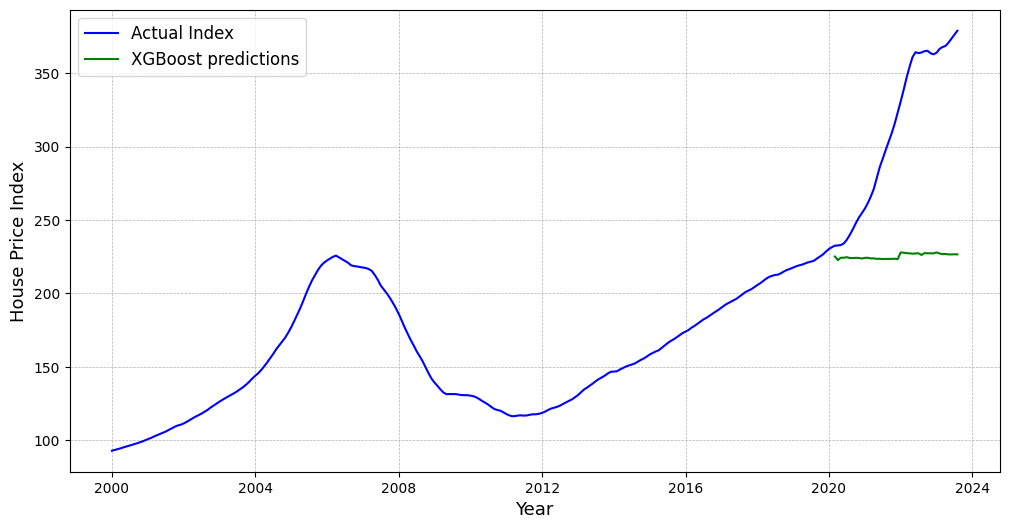

In [30]:
# Plotting the actual vs predicted values
plot_data = final_data[final_data['Date']>='2000-01-01']
plt.figure(figsize=(12, 6))
plt.plot(plot_data['Date'], plot_data['Index_SA'], label='Actual Index', color='blue', linestyle='-', linewidth=1.5)
plt.plot(results_df['Date'], results_df['Predicted'], label='XGBoost predictions', color='green', linestyle='-', linewidth=1.5)


plt.xlabel('Year', fontsize=13)
plt.ylabel('House Price Index', fontsize=13)

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [31]:
from sklearn.model_selection import GridSearchCV

# Define a set of parameters to test
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3,5,7],
    'learning_rate': [0.01,0.1, 0.2],
    # Add other parameters here
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

grid_search.fit(X, y)

# Print the best parameters and the lowest RMSE
print("Best parameters found: ", grid_search.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_search.best_score_)))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Lowest RMSE found:  46.70436856186047


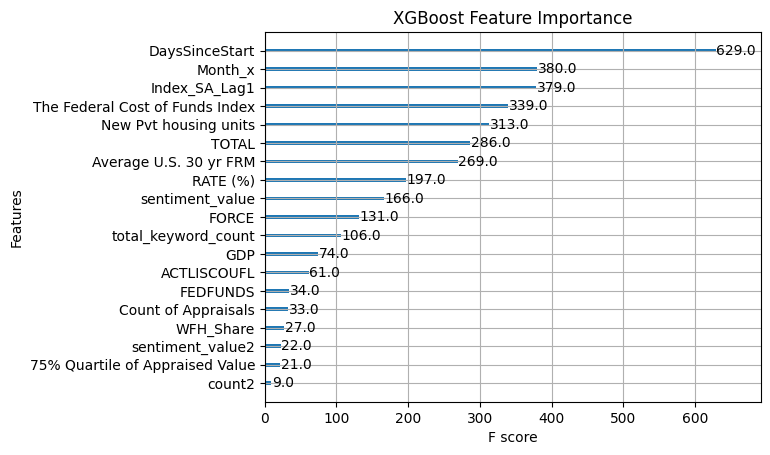

In [32]:
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.title("XGBoost Feature Importance")
plt.show()

## ARIMA model
An ARIMA model is used for time series forecasting of housing prices. The model includes steps like checking for stationarity, differencing the series, and fitting the model.

Please note that the ARIMA model outperforms other models. However, this could be due to its inability to handle null values, which restricts the training data to the period after 2013. Additionally, the ARIMA model has a limited number of predictors compared to other models.

In [33]:
import statsmodels.api as sm

arima_data = final_data.dropna(subset=["DaysSinceStart", "Index_SA", "Average U.S. 30 yr FRM","The Federal Cost of Funds Index", 'FORCE', 'RATE (%)', 'Mean Appraised Value', "sentiment_value", 'count','WFH_Share'])

split_date = pd.Timestamp('2020-03-01')
train = arima_data.loc[arima_data['Date'] < split_date].copy()
test = arima_data.loc[arima_data['Date'] >= split_date].copy()

# Perform Augmented Dickey-Fuller test on 'Index_SA'
result = sm.tsa.adfuller(train['Index_SA'])

# Output the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")
    print("Series is stationary")


# Differencing the series once (d=1)
train_diff1 = train['Index_SA'].diff().dropna()

# ADF test on the differenced series
result_diff1 = sm.tsa.adfuller(train_diff1)
print('\nDifferenced Series (d=1) ADF Test:')
print('ADF Statistic: %f' % result_diff1[0])
print('p-value: %f' % result_diff1[1])

# Interpretation
if result_diff1[1] > 0.05:
    print("Series is still not stationary, consider differencing again (d=2)")
else:
    print("Series is stationary with d=1")

ADF Statistic: -0.014129
p-value: 0.957348
Critical Values:
	1%: -3.513
	5%: -2.897
	10%: -2.586
Series is not stationary

Differenced Series (d=1) ADF Test:
ADF Statistic: -3.137505
p-value: 0.023899
Series is stationary with d=1


<Figure size 1000x600 with 0 Axes>

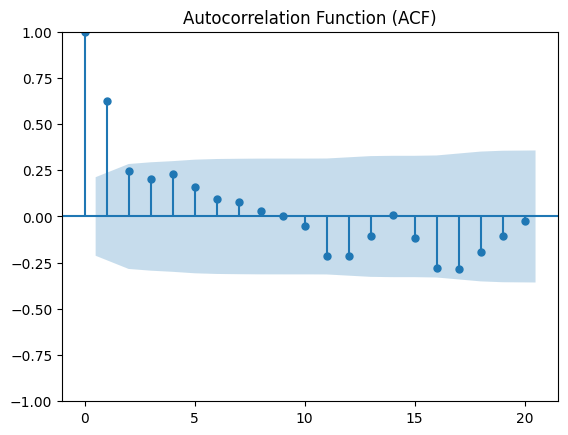

<Figure size 1000x600 with 0 Axes>

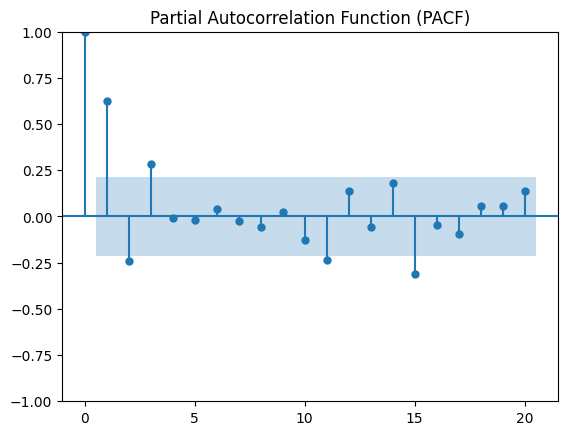

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
stationary_series = train_diff1  # Replace with your stationary series

# Plot ACF
plt.figure(figsize=(10, 6))
plot_acf(stationary_series, lags=20, alpha=0.05)  # You can adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(10, 6))
plot_pacf(stationary_series, lags=20, method='ywm', alpha=0.05)  # Adjust lags as needed, method is for PACF calculation
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Mean Squared Error: 89.10678331388334


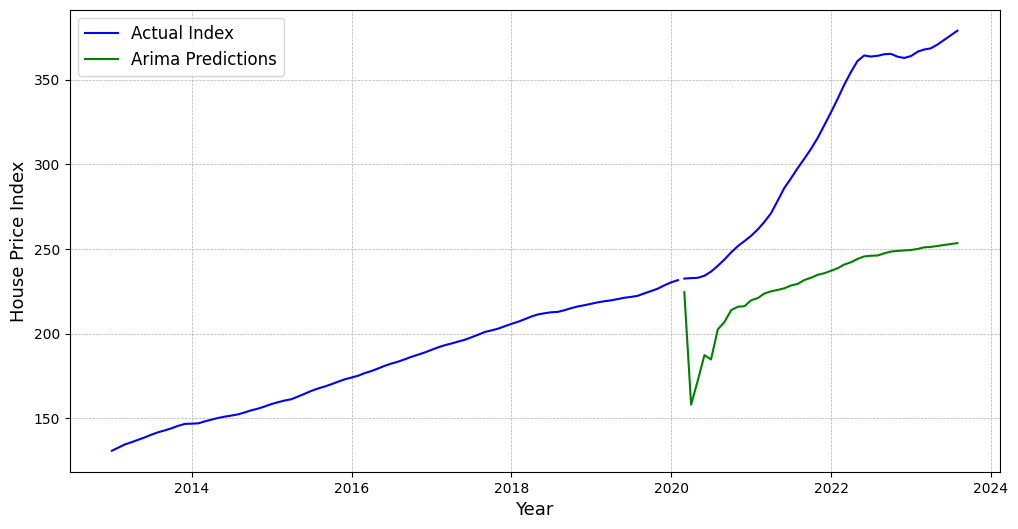

In [35]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

arima_data = final_data.dropna(subset=["Index_SA", "Average U.S. 30 yr FRM","The Federal Cost of Funds Index", 'FORCE', 'RATE (%)',  "sentiment_value", 'count','Mean Appraised Value','GDP','WFH_Share'])

# The split is based on predefined split date
split_date = pd.Timestamp('2020-03-01')
train = arima_data.loc[arima_data['Date'] < split_date].copy()
test = arima_data.loc[arima_data['Date'] >= split_date].copy()


# Now, proceeding with the ARIMA model
model = ARIMA(train['Index_SA'], order=(2, 1, 0), exog=train[["The Federal Cost of Funds Index", "Average U.S. 30 yr FRM", 'FORCE', 'RATE (%)', "sentiment_value", 'count', 'Mean Appraised Value', 'GDP','WFH_Share']])
fitted_model = model.fit()

# Predict on the test set
test_predictions = fitted_model.predict(start=train.shape[0], end=train.shape[0] + test.shape[0] - 1,
                                        exog=test[["The Federal Cost of Funds Index", "Average U.S. 30 yr FRM",'FORCE', 'RATE (%)', "sentiment_value", 'count', 'Mean Appraised Value','GDP','WFH_Share']])

# Calculate Mean Squared Error
rmse_arima = mean_squared_error(test['Index_SA'], test_predictions, squared=False)
print(f'Mean Squared Error: {rmse_arima}')

plt.figure(figsize=(12, 6))

# Plotting with original date values
plt.plot(train['Date'], train['Index_SA'], color='blue')
plt.plot(test['Date'], test['Index_SA'], label='Actual Index', color='blue')
plt.plot(test['Date'], test_predictions, label='Arima Predictions', color='green')

plt.legend(fontsize = 12)
plt.xlabel('Year', fontsize = 13)
plt.ylabel('House Price Index', fontsize = 13)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


## Random Forest Model
A Random Forest model is used for prediction. The process includes training the model, predicting, and evaluating its performance.

In [38]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100)

# Dropping rows with NaN values
X_train_dropped = X_train.dropna()
y_train_dropped = y_train[X_train_dropped.index]

# Fit the model with dropped NaN values
rf_model.fit(X_train_dropped, y_train_dropped)


y_pred_rf = rf_model.predict(X_test)

rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

print(rmse_rf)

104.99566839720201


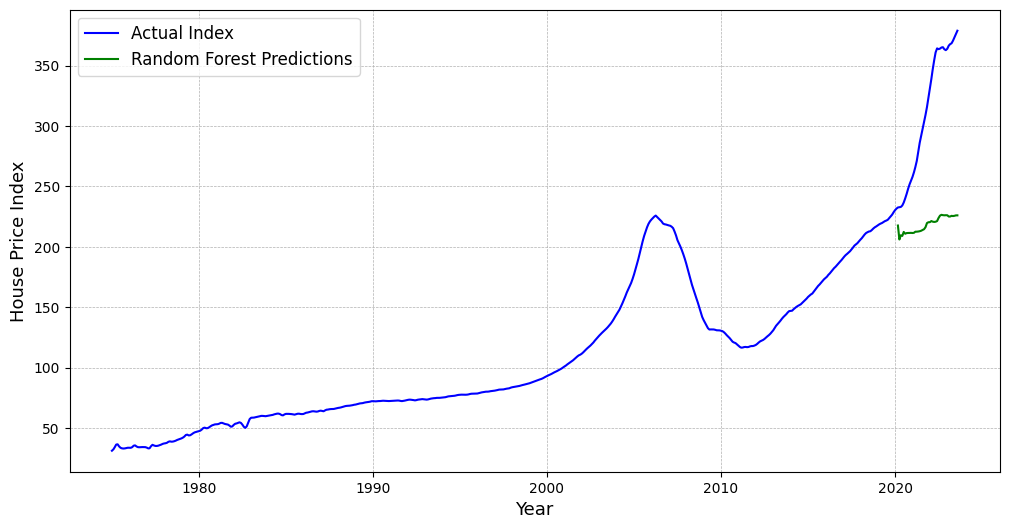

In [40]:
# Plotting the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(final_data['Date'], final_data['Index_SA'], label='Actual Index', color='blue', linestyle='-', linewidth=1.5)
plt.plot(results_df['Date'], y_pred_rf, label='Random Forest Predictions', color='green', linewidth=1.5)

plt.xlabel('Year', fontsize=13)
plt.ylabel('House Price Index', fontsize=13)
plt.legend(fontsize=12)

plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

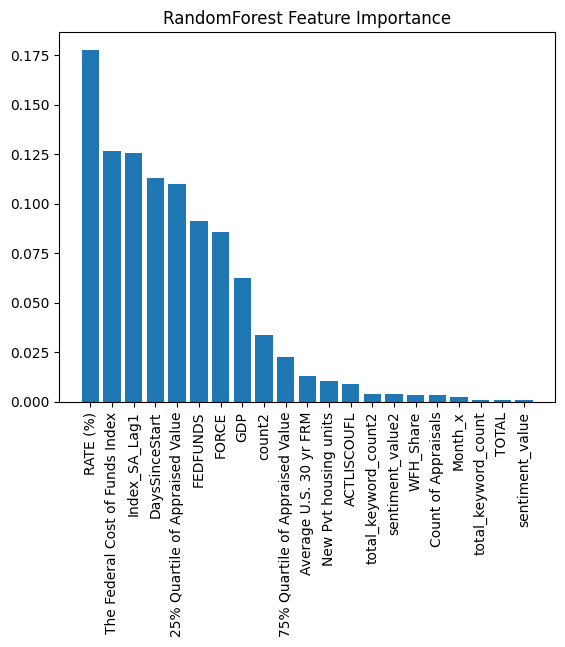

In [41]:
# After training the RandomForest model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure()
plt.title("RandomForest Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()


## ChatGPT Model
The ChatGPT predictions are compared against actual data to evaluate its performance. This includes plotting the actual vs predicted values.

In [42]:
chatgpt_pred = merged_data[merged_data['Date']>='2020-03-01']

In [43]:
rmse_cg = mean_squared_error(y_test, chatgpt_pred['One Month prior'], squared=False)
rmse_cg

38.755827697232185

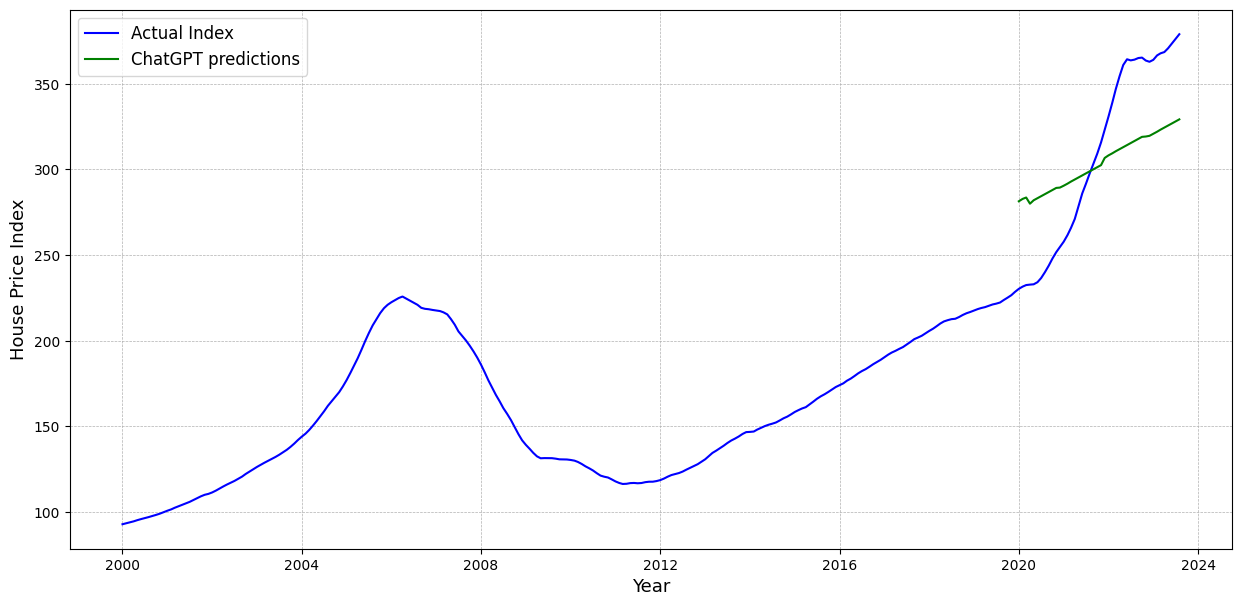

In [44]:
# Plotting the actual vs predicted values
merged_data = merged_data[merged_data['Date']>='2000-01-01']
plt.figure(figsize=(15, 7))
plt.plot(merged_data['Date'], merged_data['Index_SA'], label='Actual Index', color='blue', linestyle='-', linewidth=1.5)
plt.plot(merged_data['Date'], merged_data['One Month prior'], label='ChatGPT predictions', color='green', linestyle='-', linewidth=1.5)

plt.xlabel('Year', fontsize=13)
plt.ylabel('House Price Index', fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()